In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import csv

In [2]:
def analyse(file_path):

    # Import hall data
    df = pd.read_csv(file_path)
    df['time'] = df['time'].apply(lambda x: int(x))
    df = df[['time']]
    df['time_min'] = df['time']/1e9/60 - df.time[0]/1e9/60
    df['sensor'] = 'hall'

    # Import omega data
    df2 = pd.read_csv(file_path.replace('hall','omega'))
    df2['time'] = df2['time'].apply(lambda x: int(x))
    df2 = df2[['time']]
    df2['time_min'] = df2['time']/1e9/60 - df2.time[0]/1e9/60
    df2['sensor'] = 'omega'

    # Merge the dataframes
    merged_df = pd.concat([df, df2])
    merged_df = merged_df.sort_values(by='time')

    # Process the df
    #'''
    if 'hall' in file_path: 
        df_filtered = df.iloc[::10]
        df = df_filtered#[:-100] 
    #'''   
    df = df.reset_index(drop=True)

    # Compute GPMs
    hall_times = list(df.time)

    for i in range(len(hall_times)-1):
        frequency = 1/(hall_times[i+1]-hall_times[i])*1e9
        if frequency > 0.04 and 'omega' in file_path: frequency = 1/(hall_times[i-2]-hall_times[i-3])*1e9
        if i==0: 
            df.loc[df.time>=0, 'hall_freq'] = frequency
            df.loc[df.time>=0, 'hall_GPM'] = frequency/7.5 * 0.264172
        df.loc[df.time>=hall_times[i], 'hall_freq'] = frequency
        df.loc[df.time>=hall_times[i], 'hall_GPM'] = frequency/7.5 * 0.264172

    # Plot results
    plt.plot(list(df.time_min), list(df.hall_freq), alpha=0.3, label=f'Hall', color='green')
    #plt.plot(list(df.time), list(df.hall_GPM_filtered), alpha=0.7, label=f'Hall filtered', color='blue')
    plt.title(file_path.split('/')[-1])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [min]')
    plt.legend()
    plt.show()

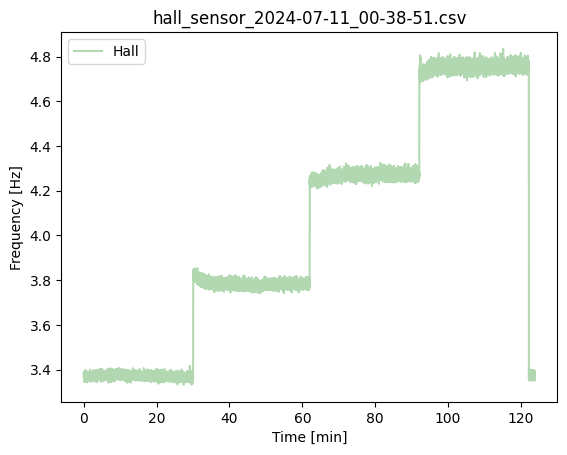

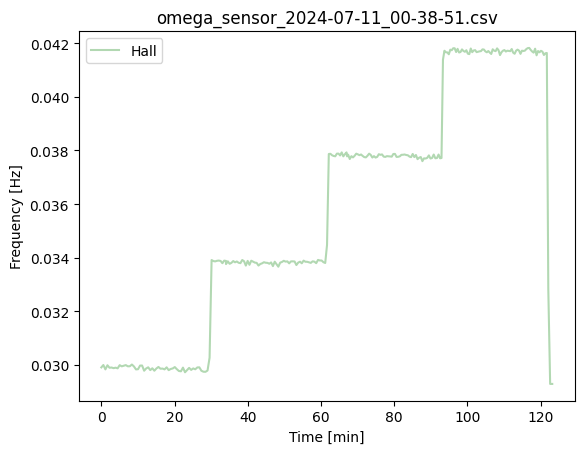

In [3]:
analyse(f'/Users/thomas/Desktop/hall_sensor_2024-07-11_00-38-51.csv')
analyse(f'/Users/thomas/Desktop/omega_sensor_2024-07-11_00-38-51.csv')

********************
0-30 min
********************
Gallons during the section: 5.4
Gallons per tick: 9.039775010044195e-05
Average GPM: 0.18
********************
34-60 min
********************
Gallons during the section: 5.4
Gallons per tick: 9.288884301785531e-05
Average GPM: 0.208
********************
64-90 min
********************
Gallons during the section: 6.0
Gallons per tick: 9.163243177201851e-05
Average GPM: 0.231
********************
94-120 min
********************
Gallons during the section: 6.5
Gallons per tick: 8.91693531792304e-05
Average GPM: 0.25


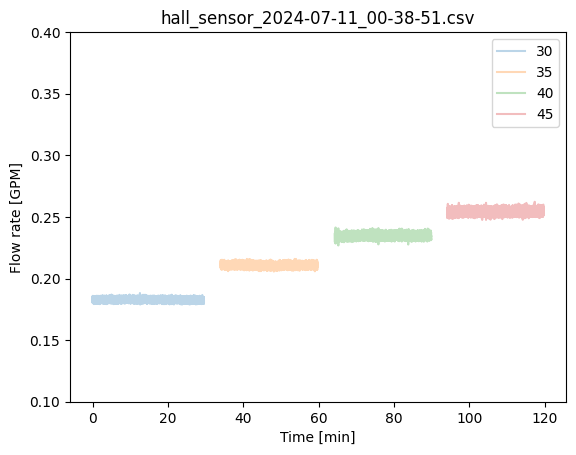

In [4]:
def analyse(file_path):

    for section in range(4):

        min_time = section*30
        max_time = (section+1)*30
        min_time = min_time+4 if min_time>=30 else min_time
        print('*'*20 + f'\n{min_time}-{max_time} min\n' + '*'*20)

        # Import hall data
        df = pd.read_csv(file_path)
        df['time'] = df['time'].apply(lambda x: int(x))
        df = df[['time']]
        df['time_min'] = df['time']/1e9/60 - df.time[0]/1e9/60
        df['sensor'] = 'Hall'

        # Import omega data
        df2 = pd.read_csv(file_path.replace('hall','omega'))
        df2['time'] = df2['time'].apply(lambda x: int(x))
        df2 = df2[['time']]
        df2['time_min'] = df2['time']/1e9/60 - df2.time[0]/1e9/60
        df2['sensor'] = 'Omega'
        #df2 = df2[df2.time_min>=min_time]
        #df2 = df2[df2.time_min<=max_time]
        #display(df2)

        # Merge the dataframes
        df = pd.concat([df, df2])
        df = df.sort_values(by='time')
        df = df.reset_index(drop=True)
    
        # Crop by sections of 30 minutes
        df = df[df.time_min>=min_time]
        df = df[df.time_min<=max_time]
        df_backup = df

        # Crop between the first and last Omega ticks
        first_omega_tick = list(df[df.sensor=='Omega'].time)[0]
        last_omega_tick = list(df[df.sensor=='Omega'].time)[-1]
        #df = df.iloc[first_omega_tick+1:last_omega_tick+1]
        df = df[df.time>=first_omega_tick]
        df = df[df.time<=last_omega_tick]

        # Count the gallons per tick
        gallons = len(df[df.sensor=='Omega'])*0.1
        print(f'Gallons during the section: {round(gallons,1)}')
        hall_gallons_per_tick = gallons / len(df[df.sensor=='Hall'])
        print(f'Gallons per tick: {hall_gallons_per_tick}')
        average = gallons/30 if min_time<30 else gallons/26
        print(f'Average GPM: {round(average,3)}')
        
        # Compute GPMs
        hall_times = list(df[df.sensor=='Hall'].time)

        for i in range(len(hall_times)-1):
            frequency = 1/(hall_times[i+1]-hall_times[i])*1e9
            if i==0: 
                df.loc[df.time>=0, 'hall_freq'] = frequency
                df.loc[df.time>=0, 'hall_GPM'] = frequency/7.5 * 0.264172
                df.loc[df.time>=0, 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60
            df.loc[df.time>=hall_times[i], 'hall_freq'] = frequency
            df.loc[df.time>=hall_times[i], 'hall_GPM'] = frequency/7.5 * 0.264172
            df.loc[df.time>=hall_times[i], 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60

        # Plot results
        #plt.plot(list(df.time_min), list(df.hall_GPM), alpha=0.3, label=f'Hall with freq', color='green')
        plt.plot(list(df.time_min), list(df.hall_GPM_gpt), alpha=0.3, label=f'{30+section*5}')
        plt.title(file_path.split('/')[-1]) #+ f': {min_time}-{max_time} min')
        plt.ylabel('Flow rate [GPM]')
        plt.xlabel('Time [min]')
        plt.ylim([0.1,0.4])
        plt.legend()

    plt.show()

analyse(f'/Users/thomas/Desktop/hall_sensor_2024-07-11_00-38-51.csv')